# Motivation

Statistically prove that drought has occured in year 2018 for xanten area by showing relationship between rise in temperature with drop in NDVI

This python code also covers correaltion analysis of QGIS mean with average temperature and Cummulative preciptaion 

# Steps to be followed for analysis

 1) Read DWD CDC Time Series Temperature <br />
 2) Merge with Station Description of Xanten <br />
 3) Filtering data of interested time range <br />
 4) Temperature analysis over Time range <br />
 5) Save data from time series analysis <br />
 6) correlation of Qgis with average temperature and cumulative preciptation <br />
 7) find confidence interval for temperature data


# Prerequisite
QGIS file with mean NDVI data for 6 station found in this analysis

The file can be found in following link:

However, if the programmer doesn't upload the excel file, the below cell will use default data obtained while developing the report

In [65]:
import pandas as pd

default_qgis_data = {'id':[32,18,15,9,1,40,38,34],
                    'MEAN_2016_05_08' : [0.798207816,0.889796897,0.864534478,0.736265187,0.845699309,0.914392008,0.081530087,0.513230467],
                    'MEAN_2016_06_10' : [0.77534111,0.842772263,0.74687512,0.763493687,0.862347455,0.725684512,0.188504494,0.524512342],
                    'MEAN_2017_05_26' : [0.671227722,0.691735776,0.906338832,0.136578793,0.930504249,0.376984843,-0.622984408,0.53763009],
                    'MEAN_2018_05_08' : [0.79474485,0.89837589,0.882192349,0.76129674,0.878997045,0.890842712,-0.018545704,0.536608263],
                    'MEAN_2018_05_11' : [0.752385138,0.862055903,0.855936285,0.702213087,0.767197773,0.860189973,0.180963576,0.493365795],
                    'MEAN_2018_06_30' : [0.4798344080,721545304,0.705694952,0.415770331,0.899321827,0.358735534,0.02140258,0.483505983]
                    }

try:
    df_ndvi = pd.read_excel('QGIS_ID.xlsx') # download excel sheet from above mentioned link and update the location 
    print('file found in local directory')
except:
    print('file not found in local directory')
    print('Using default data')
    df_ndvi = pd.DataFrame(default_qgis_data)
    

file found in local directory


## FTP Connection

### Connection Parameters

In [66]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [67]:
# The topic of interest.
# topic_dir = "/hourly/precipitation/recent/"
topic_dir = "/daily/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [68]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [69]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/kl/historical/
data/original/DWD//daily/kl/historical/

data/generated/DWD/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/


In [70]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [71]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [72]:
ret = ftp.cwd(".")

In [73]:
#ftp.quit()

### FTP Grab File Function

In [74]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [75]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [76]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [77]:
df_ftpdir.head()

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_kl_histo...,.pdf,74902,-
1,-1,DESCRIPTION_obsgermany_climate_daily_kl_histor...,.pdf,73419,-
2,-1,KL_Tageswerte_Beschreibung_Stationen.txt,.txt,267457,-
3,1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
4,3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-


### Dataframe with TS Zip Files

In [78]:
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head()

,name,ext,size,type
station_id,,,,
1,tageswerte_KL_00001_19370101_19860630_hist.zip,.zip,282024,-
3,tageswerte_KL_00003_18910101_20110331_hist.zip,.zip,887544,-
11,tageswerte_KL_00011_19800901_20181231_hist.zip,.zip,83682,-
44,tageswerte_KL_00044_19690101_20181231_hist.zip,.zip,416393,-
52,tageswerte_KL_00052_19690101_20011231_hist.zip,.zip,261747,-


### Download the Station Description File

In [79]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

KL_Tageswerte_Beschreibung_Stationen.txt


In [80]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt


In [81]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [82]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
11,1980-09-01,2020-03-01,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
44,1969-01-01,2020-03-01,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


### Select Stations Located in NRW from Station Description Dataframe

In [83]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,    98,   186,   326,   386,   390,   553,   554,   555,
              598,
            ...
            13696, 13700, 13713, 13901, 13952, 15000, 15120, 15190, 15200,
            15963],
           dtype='int64', name='station_id', length=112)

In [84]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

# df_stations.get_value()
xanten= df_stations['name'] == "Xanten (Wasserwerk)"
dfNRW = df_stations[xanten]
dfNRW.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
15190,2018-07-01,2020-03-01,18,51.6802,6.4349,Xanten (Wasserwerk),Nordrhein-Westfalen


### As Xaten station doesn't have temperature data, search for station near by

In [85]:
lat=dfNRW['latitude']
lat_all=df_stations['latitude']

isLatCovered = (df_stations['latitude'] < dfNRW.iloc[0]['latitude'] + 0.5)&(df_stations['latitude'] > dfNRW.iloc[0]['latitude'] - 0.5)
isLongCovered = (df_stations['longitude'] < dfNRW.iloc[0]['longitude'] + 0.5)&(df_stations['longitude'] > dfNRW.iloc[0]['longitude'] - 0.5)

dateFilter=(df_stations['date_from']<='2015')&(df_stations['date_to']>='2018')
# df_stations['latitude'] > dfNRW.iloc[0]['latitude']
    #latValue=df_stations['latitude']
# isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isLatCovered&isLongCovered&dateFilter] 
#print("Number of stations in NRW: \n", dfNRW.count())

dfNRW.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
617,2004-06-01,2020-03-01,47,51.8730,6.8863,Borken in Westfalen,Nordrhein-Westfalen
1078,1952-01-01,2020-03-01,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1590,1963-10-01,2020-03-01,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2629,1947-11-11,2020-03-01,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen
5064,2004-12-01,2020-03-01,37,51.2897,6.4437,Tönisvorst,Nordrhein-Westfalen


In [86]:
print(df_zips.head())

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282024    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  887544    -
11          tageswerte_KL_00011_19800901_20181231_hist.zip  .zip   83682    -
44          tageswerte_KL_00044_19690101_20181231_hist.zip  .zip  416393    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  261747    -


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [87]:
list(dfNRW.index)

[617, 1078, 1590, 2629, 5064, 13670]

In [88]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_KL_00617_20040601_20181231_hist.zip
tageswerte_KL_01078_19520101_20181231_hist.zip
tageswerte_KL_01590_19631001_20181231_hist.zip
tageswerte_KL_02629_19471111_20181231_hist.zip
tageswerte_KL_05064_20041201_20181231_hist.zip
tageswerte_KL_13670_20070531_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [89]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [90]:
from zipfile import ZipFile

In [91]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["tmk"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#     df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [92]:
df_merged_ts = temp_ts_merge()
print(df_merged_ts.head())

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_00617_20040601_20181231_hist.zip
Extract product file: produkt_klima_tag_20040601_20181231_00617.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_01078_19520101_20181231_hist.zip
Extract product file: produkt_klima_tag_19520101_20181231_01078.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_01590_19631001_20181231_hist.zip
Extract product file: produkt_klima_tag_19631001_20181231_01590.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_05064_20041201_20181231_hist.zip
Extract product file: produkt_klima_tag_20041201_20181231_05064.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_13670_20070531_20181231_hist.zip
Extract product file: produkt_klima_tag_20070531_20181231_136

In [93]:
i = 0
df_selectedDateRange = pd.DataFrame()
if df_merged_ts.index.dtype != "int64":
    try:
        df_merged_ts.reset_index(level=0, inplace=True)
    except:
        df_merged_ts.reset_index(drop=True)



add average temperature

In [94]:
df_merged_ts.head()
df_merged_ts['avgTemp']= df_merged_ts.iloc[:,1:].mean(axis=1)


The days selected are 
(a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11

In [95]:
date_a = pd.Timestamp(2016,5,8)
date_c = pd.Timestamp(2017,5,26)
date_e = pd.Timestamp(2018,5,11)

In [96]:
def subtract_years(d, years_to_subtract):
  return d - pd.DateOffset(years = 1)

In [97]:
df_date_a = df_merged_ts[(df_merged_ts['time']<=date_a) & (df_merged_ts['time'] > subtract_years(date_a,1))]
df_date_c = df_merged_ts[(df_merged_ts['time']<=date_c) & (df_merged_ts['time'] > subtract_years(date_c,1))]
df_date_e = df_merged_ts[(df_merged_ts['time']<=date_e) & (df_merged_ts['time'] > subtract_years(date_e,1))]

Plot avg temperature for 3 date range


In [98]:
%matplotlib inline

In [99]:
import matplotlib.pyplot as plt

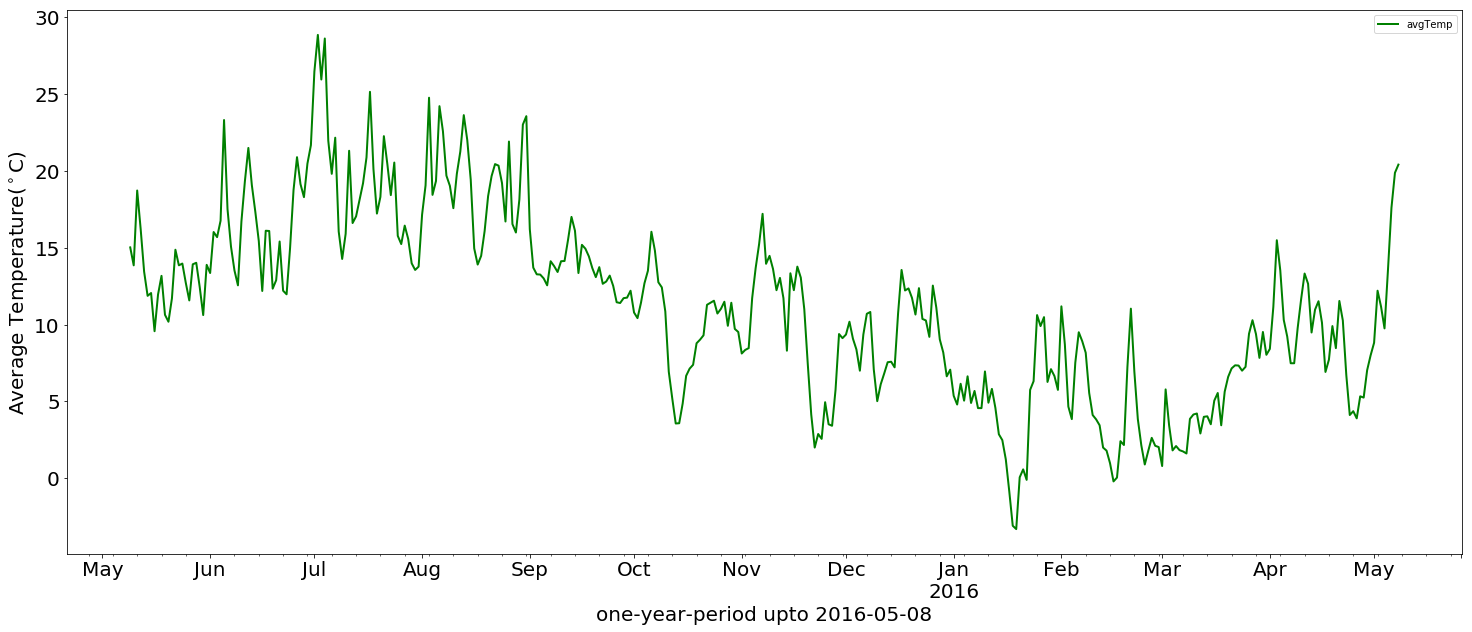

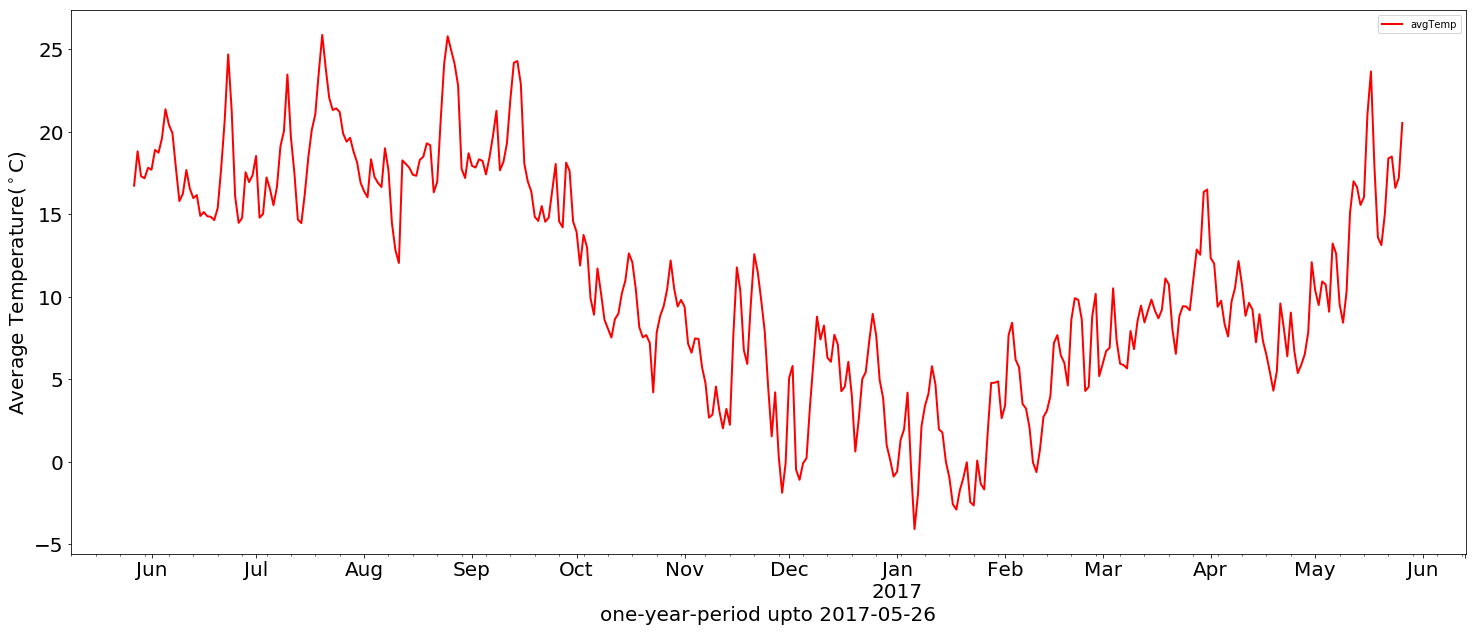

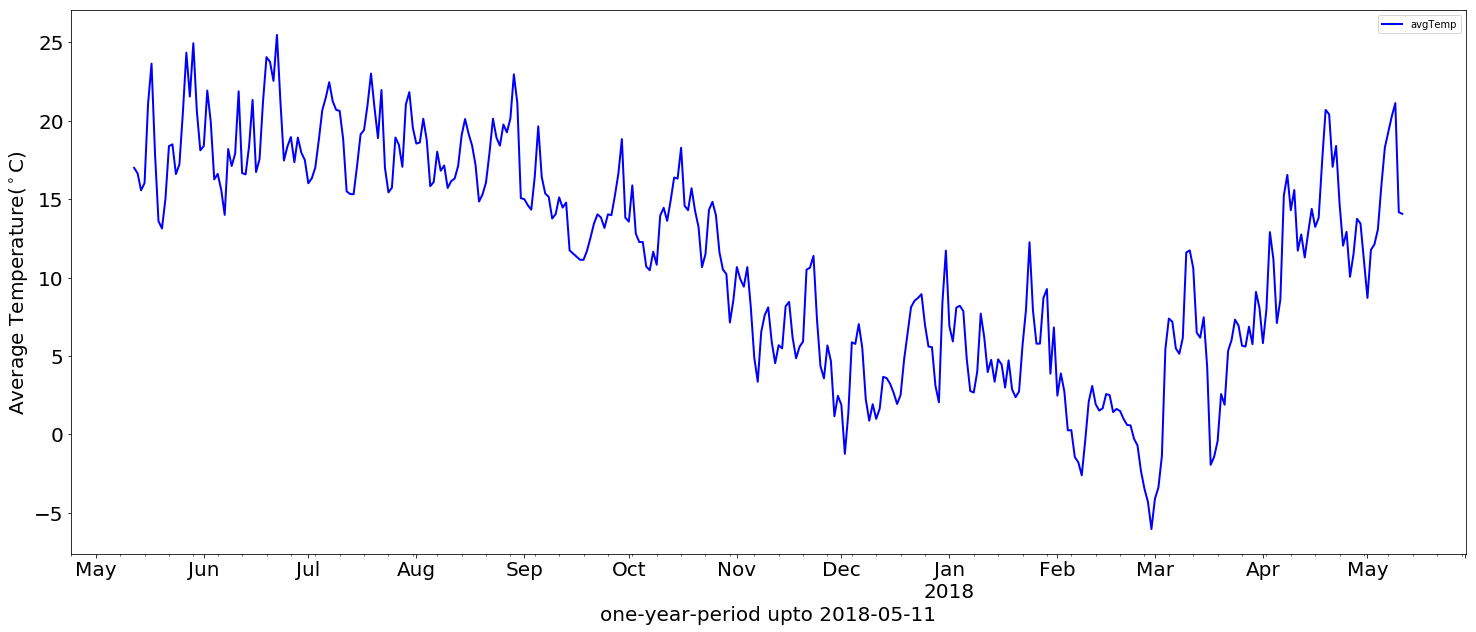

In [100]:
#The days selected are (a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11
# line plot for avg tempertaure vs time form 2015-05-09 to 2016-05-08
df_date_a.plot(kind='line',x='time',y='avgTemp',color='green', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2016-05-08', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)



# line plot for avg tempertaure vs time form 2016-05-27 to 2017-05-26
df_date_c.plot(kind='line',x='time',y='avgTemp',color='red', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2017-05-26', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)



# line plot for avg tempertaure vs time form 2018-05-12 to 2018-05-11
df_date_e.plot(kind='line',x='time',y='avgTemp',color='blue', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2018-05-11', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)


### **Find avg temperature for 3 years**



The average temperature are:
[11.220218579234976, 11.019726027397253, 11.410356164383554]


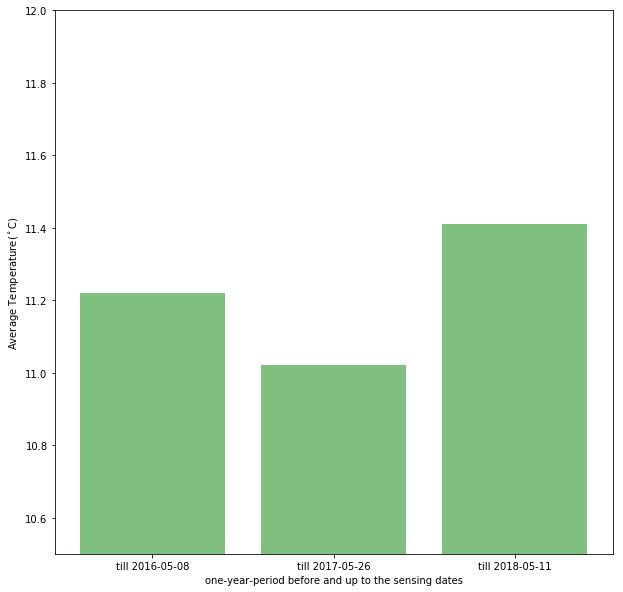

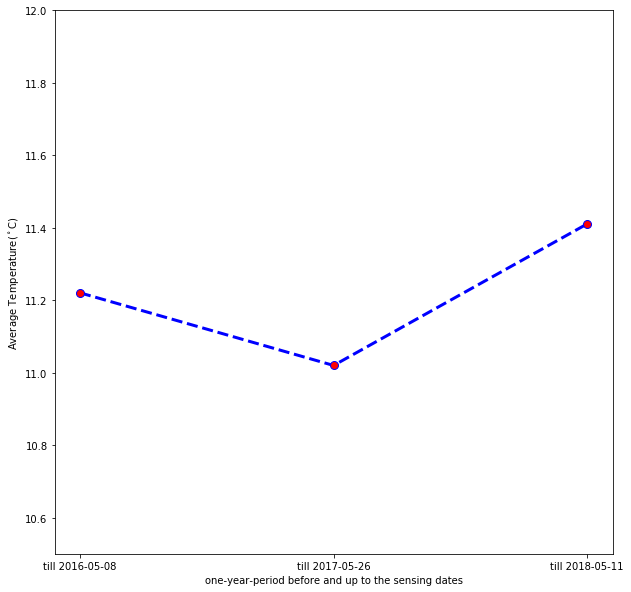

In [101]:
#The days selected are (a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11
#Displaying average temperature values for month of May and June in the year 2016, 2017, 2018 for 3 dataframe

sensing_date = ['till 2016-05-08', 'till 2017-05-26', 'till 2018-05-11']
avgTemp = [df_date_a['avgTemp'].mean(), df_date_c['avgTemp'].mean(), df_date_e['avgTemp'].mean()]
print('The average temperature are:')
print(avgTemp)

#Bar plot
plt.figure(figsize=(10,10))
plt.bar(sensing_date, avgTemp, color='green', align='center', alpha=0.5) 
axes = plt.gca()
axes.set_ylim([10.5,12])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Average Temperature($^\circ$C)')
plt.show()

#Line graph
plt.figure(figsize=(10,10))
plt.plot(sensing_date, avgTemp, color='blue',linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)
axes = plt.gca()
axes.set_ylim([10.5,12])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Average Temperature($^\circ$C)')
plt.show()

## save data

In [102]:
df_all_date = df_date_a.append(df_date_c)
df_all_date = df_all_date.append(df_date_e)
df_all_date.to_csv('average_temperature.csv',index = True)
df_all_date.shape

(1096, 8)

Heat map data


In [103]:
df_all_date.drop_duplicates(keep='first',inplace=True)
df_all_date.shape

(1081, 8)

In [104]:
df_all_date.head()

,time,617,1078,1590,2629,5064,13670,avgTemp
24651,2015-05-09,14.4,15.8,15.1,13.9,15.6,15.3,15.016667
24652,2015-05-10,13.0,14.3,14.4,13.2,14.3,13.9,13.850000
24653,2015-05-11,18.1,18.7,19.2,18.2,18.8,19.3,18.716667
24654,2015-05-12,15.6,17.4,16.3,15.1,16.4,16.5,16.216667
24655,2015-05-13,13.1,13.6,13.8,12.6,13.8,13.7,13.433333


In [105]:
station_ids = df_all_date.columns.drop(['time','avgTemp']).tolist()

In [106]:
timeseries_list = []
for id in station_ids:
  df_stations = pd.DataFrame()
  df_stations['time'] = df_all_date['time']
  df_stations['latitude'] = dfNRW.loc[id]['latitude']
  df_stations['longitude'] = dfNRW.loc[id]['longitude']
  df_stations['temp'] = df_all_date[id]
  timeseries_list.append(df_stations)

df_timeseries = pd.concat(timeseries_list)
df_timeseries.head()

,time,latitude,longitude,temp
24651,2015-05-09,51.873,6.8863,14.4
24652,2015-05-10,51.873,6.8863,13.0
24653,2015-05-11,51.873,6.8863,18.1
24654,2015-05-12,51.873,6.8863,15.6
24655,2015-05-13,51.873,6.8863,13.1


In [107]:
df_timeseries.shape

(6486, 4)

In [108]:
df_timeseries.to_csv('timeseries_temperature.csv',index= True)
# from google.colab import files
# files.download('heatmap_temperature.csv')

## data for interpolation


Drop overlapping data

In [109]:
df_all_date.drop_duplicates(keep='first',inplace=True)
df_all_date.shape

(1081, 8)

In [110]:
df_interpolation = df_all_date.transpose()
df_interpolation.drop(['time','avgTemp'],inplace=True)
df_interpolation['avgTemp'] = df_interpolation.mean(axis=1)
df_interpolation = pd.merge(dfNRW,df_interpolation, left_index=True , right_index=True)
df_interpolation[['latitude','longitude','avgTemp']].to_csv('interpolation_temperature.csv',index=True)
# from google.colab import files
# files.download('interpolation_temperature.csv')

In [111]:
sensing_data = [df_date_a,df_date_c,df_date_e]
i = 0
for df in sensing_data:
  df = df.transpose()
  df.drop(['time','avgTemp'],inplace=True)
  df['avgTemp'] = df.mean(axis=1)
  df = pd.merge(dfNRW,df, left_index=True , right_index=True)
  file_name = 'interpolation_temperature_' + sensing_date[i] + '.csv'
  df[['latitude','longitude','avgTemp']].to_csv(file_name,index=True)
  i = i + 1
#   from google.colab import files
#   files.download(file_name)

# Data from NDVI



### Upload QGIS ndvi data


In [112]:
# from google.colab import files
# uploaded = files.upload()
#df_ndvi = pd.read_excel('QGIS_ID.xlsx')

In [113]:
df_ndvi.head()

,id,MEAN_2016_05_08,MEAN_2016_06_10,MEAN_2017_05_26,MEAN_2018_05_08,MEAN_2018_05_11,MEAN_2018_06_30
0,32,0.798208,0.775341,0.671228,0.794745,0.752385,0.479834
1,18,0.889797,0.842772,0.691736,0.898376,0.862056,0.721545
2,15,0.864534,0.746875,0.906339,0.882192,0.855936,0.705695
3,9,0.736265,0.763494,0.136579,0.761297,0.702213,0.415770
4,1,0.845699,0.862347,0.930504,0.878997,0.767198,0.899322


In [114]:
df_ndvi = df_ndvi[['id','MEAN_2016_05_08','MEAN_2017_05_26','MEAN_2018_05_11']]
df_ndvi.head()

,id,MEAN_2016_05_08,MEAN_2017_05_26,MEAN_2018_05_11
0,32,0.798208,0.671228,0.752385
1,18,0.889797,0.691736,0.862056
2,15,0.864534,0.906339,0.855936
3,9,0.736265,0.136579,0.702213
4,1,0.845699,0.930504,0.767198


### adding temperature and cummulative precipitation in ndvi dataframe
#avgTemp = [11.220218579234976, 11.019726027397253, 11.410356164383554]
#cumPrecipt = [829.4000000000002, 874.0000000000003, 790.9]



In [115]:
df_ndvi['AVG_TEMP_2016_05_08'] = 11.22
df_ndvi['AVG_TEMP_2017_05_26'] = 11.01
df_ndvi['AVG_TEMP_2018_05_11'] = 11.41
df_ndvi['CUM_PRECIPIT_2016_05_08'] = 829.4
df_ndvi['CUM_PRECIPIT_2017_05_26'] = 874.0
df_ndvi['CUM_PRECIPIT_2018_05_11'] = 790.9
df_ndvi

,id,MEAN_2016_05_08,MEAN_2017_05_26,MEAN_2018_05_11,AVG_TEMP_2016_05_08,AVG_TEMP_2017_05_26,AVG_TEMP_2018_05_11,CUM_PRECIPIT_2016_05_08,CUM_PRECIPIT_2017_05_26,CUM_PRECIPIT_2018_05_11
0,32,0.798208,0.671228,0.752385,11.22,11.01,11.41,829.4,874.0,790.9
1,18,0.889797,0.691736,0.862056,11.22,11.01,11.41,829.4,874.0,790.9
2,15,0.864534,0.906339,0.855936,11.22,11.01,11.41,829.4,874.0,790.9
3,9,0.736265,0.136579,0.702213,11.22,11.01,11.41,829.4,874.0,790.9
4,1,0.845699,0.930504,0.767198,11.22,11.01,11.41,829.4,874.0,790.9
5,40,0.914392,0.376985,0.860190,11.22,11.01,11.41,829.4,874.0,790.9
6,38,0.081530,-0.622984,0.180964,11.22,11.01,11.41,829.4,874.0,790.9
7,34,0.513230,0.537630,0.493366,11.22,11.01,11.41,829.4,874.0,790.9


Create Dataframe for correaltion analysis


In [116]:
def create_dataframe_for_corelation(row):
  data_dic = {}
  dates = ['2016_05_08','2017_05_26','2018_05_11']
  number_of_sensing_dates = 3
  ndvi_start_pos = 1
  while ndvi_start_pos <= number_of_sensing_dates:
    data_dic['id'] = row['id']
    data_dic['meanNDVI'] = row.iloc[ndvi_start_pos]
    data_dic['avgTemp'] = row.iloc[ndvi_start_pos + number_of_sensing_dates ]
    data_dic['cumPrecipt'] = row.iloc[ndvi_start_pos + 2 * number_of_sensing_dates ]
    data_dic['tillDate'] = dates[ndvi_start_pos-1]
    data_list.append(data_dic)
    data_dic = {}
    ndvi_start_pos = ndvi_start_pos + 1

In [117]:
data_list = []
df_ndvi.apply(create_dataframe_for_corelation,axis =1)
df_correlation = pd.DataFrame(data_list)
df_correlation.head()

,avgTemp,cumPrecipt,id,meanNDVI,tillDate
0,11.22,829.4,32.0,0.798208,2016_05_08
1,11.01,874.0,32.0,0.671228,2017_05_26
2,11.41,790.9,32.0,0.752385,2018_05_11
3,11.22,829.4,18.0,0.889797,2016_05_08
4,11.01,874.0,18.0,0.691736,2017_05_26


### find corelation for each id

In [118]:
uniqueId = df_correlation['id'].unique()

In [119]:
for id in uniqueId:
  print('corelation of the id',id)
  print(df_correlation[df_correlation['id']==id][['meanNDVI','avgTemp','cumPrecipt']].corr(method ='pearson'))

corelation of the id 32.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.653165   -0.663324
avgTemp     0.653165  1.000000   -0.999909
cumPrecipt -0.663324 -0.999909    1.000000
corelation of the id 18.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.811291   -0.819107
avgTemp     0.811291  1.000000   -0.999909
cumPrecipt -0.819107 -0.999909    1.000000
corelation of the id 15.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000 -0.944538    0.948884
avgTemp    -0.944538  1.000000   -0.999909
cumPrecipt  0.948884 -0.999909    1.000000
corelation of the id 9.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.854967   -0.861889
avgTemp     0.854967  1.000000   -0.999909
cumPrecipt -0.861889 -0.999909    1.000000
corelation of the id 1.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000 -0.999978    0.999799
avgTemp    -0.999978  1.000000   -0.999909
cumPrecipt  0.999799 -0.999909    1.000000
corelation o

# Plot NDVI with AvgTemp

Scatter plot for meanNDVi with avgTemp and cumprecipt


forest and pasture id are 1, 34

In [120]:
forestIds = [1,34]

<Figure size 720x720 with 0 Axes>

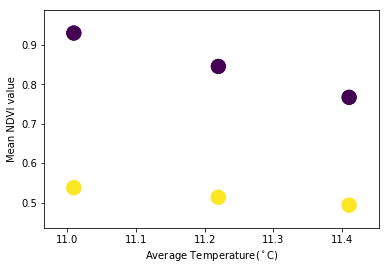

In [121]:
try:
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    scatter = ax.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['avgTemp'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    plt.xlabel('Average Temperature($^\circ$C)')
    plt.ylabel('Mean NDVI value')
except:
    plt.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['avgTemp'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    plt.xlabel('Average Temperature($^\circ$C)')
    plt.ylabel('Mean NDVI value')

# Plot NDVI with Cumulative preciptation

<Figure size 720x720 with 0 Axes>

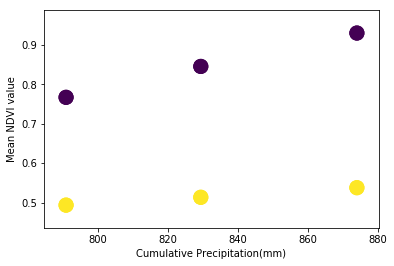

In [59]:
try:
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    scatter = ax.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['cumPrecipt'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    plt.xlabel('Cumulative Precipitation(mm)')
    plt.ylabel('Mean NDVI value')

except:
    plt.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['cumPrecipt'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    plt.xlabel('Cumulative Precipitation(mm)')
    plt.ylabel('Mean NDVI value')

# Average temperature vs Cumulative precpitation


In [60]:
avgTemp = [11.220218579234976, 11.019726027397253, 11.410356164383554]
cumPrecipt = [829.4000000000002, 874.0000000000003, 790.9]


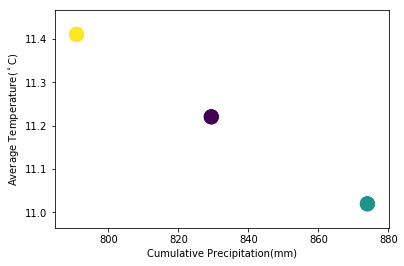

In [61]:
try:
    fig, ax = plt.subplots()
    scatter = ax.scatter(cumPrecipt,avgTemp, c = [2016,2017,2018], s= 200)
    plt.ylabel('Average Temperature($^\circ$C)')
    plt.xlabel('Cumulative Precipitation(mm)')
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
except:
    plt.scatter(cumPrecipt,avgTemp, c = [2016,2017,2018], s= 200)
    plt.ylabel('Average Temperature($^\circ$C)')
    plt.xlabel('Cumulative Precipitation(mm)')

### Confidence interval of Temperature


In [62]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [63]:
df_all_date.head()

,time,617,1078,1590,2629,5064,13670,avgTemp
24651,2015-05-09,14.4,15.8,15.1,13.9,15.6,15.3,15.016667
24652,2015-05-10,13.0,14.3,14.4,13.2,14.3,13.9,13.850000
24653,2015-05-11,18.1,18.7,19.2,18.2,18.8,19.3,18.716667
24654,2015-05-12,15.6,17.4,16.3,15.1,16.4,16.5,16.216667
24655,2015-05-13,13.1,13.6,13.8,12.6,13.8,13.7,13.433333


In [64]:
mean_confidence_interval(df_all_date['avgTemp'])

(11.13109466543324, 10.740761590728471, 11.521427740138009)

In [125]:
df_correlation.head()

,avgTemp,cumPrecipt,id,meanNDVI,tillDate
0,11.22,829.4,32.0,0.798208,2016_05_08
1,11.01,874.0,32.0,0.671228,2017_05_26
2,11.41,790.9,32.0,0.752385,2018_05_11
3,11.22,829.4,18.0,0.889797,2016_05_08
4,11.01,874.0,18.0,0.691736,2017_05_26
